In [1]:
import tensorflow as tf
import numpy as np
import math
import utils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

Using TensorFlow backend.


In [5]:
import keras
from keras.datasets import cifar10
(x_train, _), (x_test, _) = cifar10.load_data()

In [6]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

In [8]:
# Adding GBLUR
x_train, x_train_noisy = utils.cifar10_gblur(x_train)
x_test, x_test_noisy = utils.cifar10_gblur(x_test)

5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
50000/50000 images done!
Adding GBLUR done!
5000/10000 images done!
10000/10000 images done!
Adding GBLUR done!


In [11]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape
#% matplotlib inline

((650000, 32, 32, 3),
 (650000, 32, 32, 3),
 (130000, 32, 32, 3),
 (130000, 32, 32, 3))

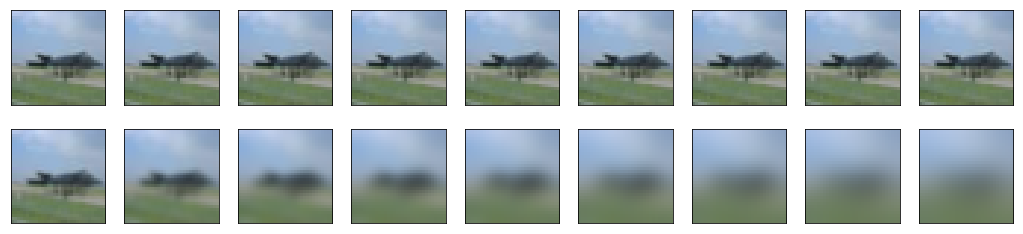

In [18]:
# Displaying noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i+4*13*150].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_noisy[i+4*13*150].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [2]:
import keras
from keras import losses
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate

L = 5  # Total number of layers
S = 2  # Number of shared layers
F = [16, 32, 64, 128, 256]     # Number of clean filters including input

# Clean different encoding layers
inp = Input(shape=(32, 32, 3))
enc = inp
for i in range(L-S):
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(2, 2))(enc)

clean_diff_enc = Model(inputs=[inp], outputs=[enc])
clean_diff_enc.compile(optimizer='adadelta', loss='mean_squared_error')

# Distorted different encoding layers
inp = Input(shape=(32, 32, 3))
enc = inp
for i in range(L-S):
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(2, 2))(enc)

dist_diff_enc = Model(inputs=[inp], outputs=[enc])
dist_diff_enc.compile(optimizer='adadelta', loss='mean_squared_error')

# Shared Encoding Layers
inp = Input(shape=(4, 4, F[L-S-1]))
enc = inp
for i in range(L-S, L):
    enc = Conv2D(F[i], (3, 3), activation='relu', padding='same', strides=(2, 2))(enc)

comm_enc = Model(inputs=[inp], outputs=[enc])
comm_enc.compile(optimizer='adadelta', loss='mean_squared_error')

# Shared Decoding Layers
inp = Input(shape=(1, 1, F[L-1]))
dec = inp
for i in range(L-S-1, L-1)[::-1]:
    dec = UpSampling2D((2, 2))(dec)
    dec = Conv2D(F[i], (3, 3), activation='relu', padding='same')(dec)
comm_dec = Model(inputs=[inp], outputs=[dec])
comm_dec.compile(optimizer='adadelta', loss='mean_squared_error')

# Clean different decoding layers
inp = Input(shape=(4, 4, F[L-S-1]))
dec = inp
for i in range(-1,L-S)[::-1]:
    if i == -1:
        recon = Conv2D(3, (3, 3), activation='relu', padding='same')(dec)
    else:
        dec = UpSampling2D((2, 2))(dec)
        dec = Conv2D(F[i], (3, 3), activation='relu', padding='same')(dec)
clean_diff_dec = Model(inputs=[inp], outputs=[recon])
clean_diff_dec.compile(optimizer='adadelta', loss='mean_squared_error')

# Distorted different decoding layers
inp = Input(shape=(4, 4, F[L-S-1]))
dec = inp
for i in range(-1,L-S)[::-1]:
    if i == -1:
        recon = Conv2D(3, (3, 3), activation='relu', padding='same')(dec)
    else:
        dec = UpSampling2D((2, 2))(dec)
        dec = Conv2D(F[i], (3, 3), activation='relu', padding='same')(dec)
dist_diff_dec = Model(inputs=[inp], outputs=[recon])
dist_diff_dec.compile(optimizer='adadelta', loss='mean_squared_error')

# clean input
clean_input = Input(shape = (32, 32, 3))
clean_pred = clean_diff_dec(comm_dec(comm_enc(clean_diff_enc(clean_input))))

# distorted Input
dist_input = Input(shape = (32, 32, 3))
dist_pred = dist_diff_dec(comm_dec(comm_enc(dist_diff_enc(dist_input))))

# IQA Model
IQA_model = Model(inputs=[clean_input, dist_input], outputs=[clean_pred, dist_pred])
IQA_model.compile(optimizer='adadelta', loss='mean_squared_error')

Fontconfig warning: ignoring UTF-8: not a valid region tag



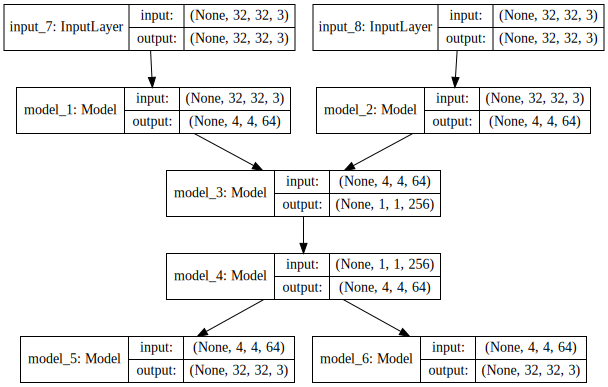

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(IQA_model, show_shapes=True).create(prog='dot', format='svg'))

In [4]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(IQA_model, to_file='my_models/cdA_gblur_model.png', show_shapes=True)

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [ ]:
from keras.callbacks import TensorBoard
import sys
IQA_model.fit([x_train, x_train_noisy],
              [x_train, x_train_noisy],
              epochs=100,
#              verbose = 2,
              batch_size=256,
              shuffle=True,
              validation_data=([x_test, x_test_noisy], 
                               [x_test, x_test_noisy]),
              callbacks=[TensorBoard(log_dir='tmp/IQA_model', histogram_freq=0, 
                                     write_graph=True, write_images=True)])

In [ ]:
decoded_imgs = IQA_model.predict([x_test, x_test_noisy])

vis_clean = utils.visualize(x_test, [32, 32], [1, 1], [13, 13], color=1, channels='last')
vis_dist = utils.visualize(x_test_noisy, [32, 32], [1, 1], [13, 13], color=1, channels='last')
vis_clean_filt = utils.visualize(decoded_imgs[0], [32, 32], [1, 1], [13, 13], color=1, channels='last')
vis_dist_filt = utils.visualize(decoded_imgs[1], [32, 32], [1, 1], [13, 13], color=1, channels='last')

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1), plt.imshow(vis_clean)
plt.subplot(2, 2, 2), plt.imshow(vis_dist)
plt.subplot(2, 2, 3), plt.imshow(vis_clean_filt)
plt.subplot(2, 2, 4), plt.imshow(vis_dist_filt)
plt.show()